# Optimization using hyperopt and BaysianOptimization

Common imports for all sections.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Function to optimize

Define the function to minimize.

In [2]:
def function(x, y):
    x0, y0 = 1.2, 0.7
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    return 1.0 - np.abs(np.cos(2.0*np.pi*r))*np.exp(-r)

Visualize the function.

In [3]:
x = np.linspace(-3.0, 3.0, 101)
y = np.linspace(-3.0, 3.0, 101)
X, Y = np.meshgrid(x, y)
data = function(X, Y)

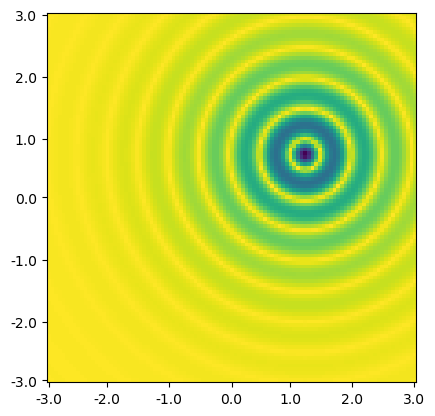

In [4]:
_ = plt.imshow(data, origin='lower')
_ = plt.xticks(np.linspace(0, 100, 7, dtype=np.int32), np.linspace(-3.0, 3.0, 7))
_ = plt.yticks(np.linspace(0, 100, 7, dtype=np.int32), np.linspace(-3.0, 3.0, 7))

## hyperopt

Required imports.

In [5]:
from hyperopt import fmin, hp, rand, STATUS_OK, tpe, Trials
from hyperopt.pyll.stochastic import sample
import time

### Sample space

Define the optimization space.  The two parameters are $x$ and $y$, and the sample points should be uniformly distributed in the intervals $x \in [-3, 3]$ and $y \in [-3, 3]$.

In [6]:
space = (hp.uniform('x', -3.0, 3.0), hp.uniform('y', -3.0, 3.0))

We can sample the space using the `sample` method, e.g.,

In [7]:
for _ in range(5):
    print(sample(space))

(1.2705149475081843, 2.9511352623203617)
(1.5987647157267206, -0.7543124296677615)
(0.889061703588971, 1.124895269215477)
(0.28101486839536527, 1.2672777984597383)
(2.0650550342215706, 1.4610177583744397)


### Objective function

The `sample` function returns tuples of $x$ and $y$ values, so the obje ctive function should take a tuple as argument.  Having a dictionary as a return type, rather than simply the value makes it easier to retrieve information from the `Trials` object that can be passed to `fmin`.

In [8]:
def objective(values):
    return {
        'loss': function(values[0], values[1]),
        'x': values[0], 'y': values[1],
        'status': STATUS_OK, 'time': time.time(),
    }

A `Trials` object keeps track of the optimization process, so that it can be visualized or otherwise inspected when the optimization is done.

### Trials

Define a function that takes a `Trial` object, and returns two numpy arrays with the $x$ and $y$ coordinates of the sample points.

In [9]:
def sample_trace(trials):
    x = np.empty(len(trials))
    y = np.empty(len(trials))
    for i, result in enumerate(trials.results):
        x[i] = result['x']
        y[i] = result['y']
    return x, y

### Tree of Parzen estimators (TPE)

In [10]:
trials = Trials()

In [11]:
best = fmin(objective, max_evals=100, space=space,
            algo=tpe.suggest, trials=trials)

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 723.99trial/s, best loss: 0.3872706142114245]


In [12]:
print(best['x'], best['y'])

0.7162563408135711 0.6542161024067286


In [13]:
sample_x, sample_y = sample_trace(trials)

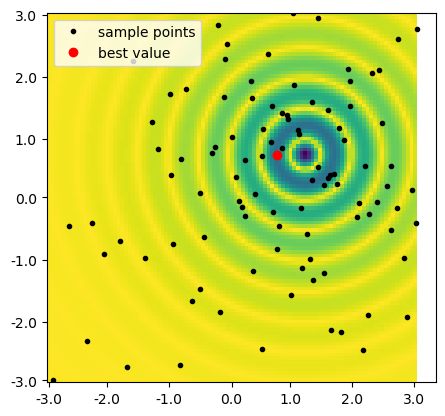

In [14]:
def scale(z):
    return (3.0 + z)*101.0/6.0

_ = plt.imshow(data, origin='lower')
_ = plt.plot(scale(sample_x), scale(sample_y), 'k.', label='sample points')
_ = plt.plot((scale(best['x']), ), (scale(best['y']), ), 'ro', label='best value')
_ = plt.xticks(np.linspace(0, 100, 7, dtype=np.int32), np.linspace(-3.0, 3.0, 7))
_ = plt.yticks(np.linspace(0, 100, 7, dtype=np.int32), np.linspace(-3.0, 3.0, 7))
_ = plt.legend()

### Random search

In [15]:
trials = Trials()

In [16]:
best = fmin(objective, max_evals=100, space=space,
            algo=rand.suggest, trials=trials)

100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3182.93trial/s, best loss: 0.4471734199442068]


In [17]:
print(best['x'], best['y'])

0.9369298489451197 0.39120676050733394


In [18]:
sample_x, sample_y = sample_trace(trials)

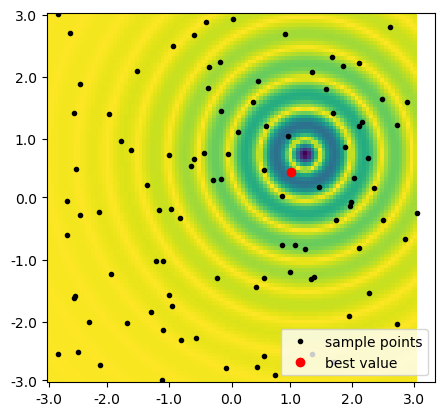

In [19]:
def scale(z):
    return (3.0 + z)*101.0/6.0

_ = plt.imshow(data, origin='lower')
_ = plt.plot(scale(sample_x), scale(sample_y), 'k.', label='sample points')
_ = plt.plot((scale(best['x']), ), (scale(best['y']), ), 'ro', label='best value')
_ = plt.xticks(np.linspace(0, 100, 7, dtype=np.int32), np.linspace(-3.0, 3.0, 7))
_ = plt.yticks(np.linspace(0, 100, 7, dtype=np.int32), np.linspace(-3.0, 3.0, 7))
_ = plt.legend()

Although both the TPE and random search found the global optimum, it is clear that the TPE algorithm samples the parameter space in a more intelligent way.

### Parameter space with choices

The space below represents the parameter space for an OpenMP parallel for loop schedule (static, dynamic or guided) and the chunck size for each.

In [20]:
space = hp.choice('schedule', [
    ('static', hp.qloguniform('chunk', 2, 11, 10)),
    ('dynamics', hp.qloguniform('chunk', 2, 11, 10)),
    ('guided', hp.qloguniform('chunk', 2, 11, 10)),
])

In [21]:
for _ in range(5):
    print(sample(space))

('dynamics', 40.0)
('guided', 10.0)
('guided', 5320.0)
('dynamics', 10.0)
('guided', 560.0)


## BaysianOptimizer

Required imports.

In [22]:
from bayes_opt import BayesianOptimization

Define the objective function.

In [23]:
def objective(x, y):
    return -function(x, y)

In [24]:
param_bounds = {'x': (-3.0, 3.0), 'y': (-3.0, 3.0)}

In [25]:
optimizer = BayesianOptimization(f=objective, pbounds=param_bounds, random_state=1234)

In [26]:
optimizer.maximize(n_iter=100, init_points=3)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -0.9551   | -1.851    | 0.7327    |
| 2         | -0.8939   | -0.3736   | 1.712     |
| 3         | -0.9122   | 1.68      | -1.364    |
| 4         | -0.9028   | -0.2245   | -0.8474   |
| 5         | -0.9142   | 1.691     | -1.365    |
| 6         | -0.9707   | -0.1963   | 1.8       |
| 7         | -0.8689   | -0.471    | 1.664     |
| 8         | -0.8957   | -0.5939   | 1.773     |
| 9         | -0.9045   | -0.4766   | 1.492     |
| 10        | -0.8889   | -0.6737   | 1.595     |
| 11        | -0.9828   | -2.453    | 2.113     |
| 12        | -0.8836   | 1.322     | -1.361    |
| 13        | -0.9277   | 1.394     | -1.114    |
| 14        | -0.9467   | -0.07426  | -1.267    |
| 15        | -0.9938   | 1.312     | -1.557    |
| 16        | -0.9594   | 0.2099    | 2.795     |
| 17        | -0.8635   | 1.224     | -1.261    |
| 18        | -0.863    | 1.048     | -1.267    |


In [27]:
best = optimizer.max

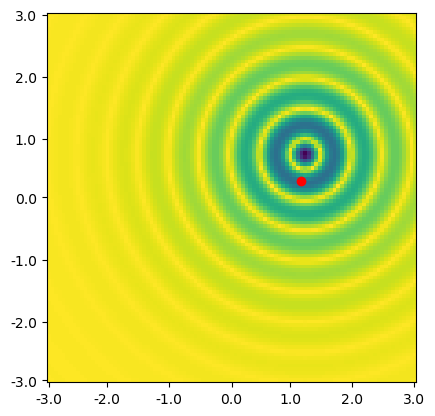

In [28]:
def scale(z):
    return (3.0 + z)*101.0/6.0

best_x = best['params']['x']
best_y = best['params']['y']
_ = plt.imshow(data, origin='lower')
_ = plt.plot((scale(best_x), ), (scale(best_y), ), 'ro', label='best value')
_ = plt.xticks(np.linspace(0, 100, 7, dtype=np.int32), np.linspace(-3.0, 3.0, 7))
_ = plt.yticks(np.linspace(0, 100, 7, dtype=np.int32), np.linspace(-3.0, 3.0, 7))